# Contrast Cue

In [1]:
import cv2 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import numpy as np
import numpy as pynum_float
import math
from scipy.spatial import distance
import os
from PIL import Image
import utils
from sklearn.cluster import KMeans
import sys

Image Shape: (200, 600, 3)
Red Channel (200, 600)
Total Pixels are: 120000


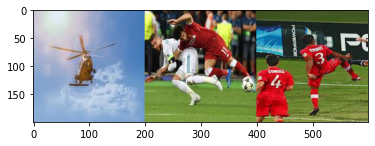

In [40]:
#Reading Image
#Boat image was good
# I = mpimg.imread('./Co-Salient_Photos/Image4.jpeg')  
# plt.imshow(I) 
# print("Image Shape:",I.shape)
# R=I[:,:,0]
# G=I[:,:,1]
# B=I[:,:,2]

# print("Red Channel",R.shape)

#Merging Image

# folder='./Photos/'
# for filename in os.listdir(folder):
#     img = Image.open(os.path.join(folder,filename))
#     img=img.resize((200,200), Image.ANTIALIAS)
# #         plt.imshow(I) 
#     print(img.size)
#     img.save(filename+'_temp'+'.jpg')
# #         if img is not None:
# #             total+=img.shape[0]*img.shape[1]
# # #             images.append(img)


#Reading merge Image

I= mpimg.imread('Merge1.jpg')  
plt.imshow(I) 
print("Image Shape:",I.shape)
R=I[:,:,0]
G=I[:,:,1]
B=I[:,:,2]

print("Red Channel",R.shape)

total=I.shape[0]*I.shape[1]
print("Total Pixels are:",total)

KMeans(n_clusters=6)

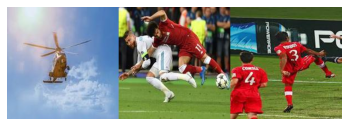

In [67]:
#Clustering based on colors
image = cv2.imread('Merge1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)

image = image.reshape((image.shape[0] * image.shape[1], 3))

image.shape # (120000,3)

n_clusters =6
clt = KMeans(n_clusters =n_clusters)
clt.fit(image)

# import numpy as np
# import cv2
# def centroid_histogram(clt):
#     numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
#     (hist, _) = np.histogram(clt.labels_, bins = numLabels)

#     hist = hist.astype("float")
#     hist /= hist.sum()

#     return hist


# def plot_colors(hist, centroids):

#     bar = np.zeros((50, 300, 3), dtype = "uint8")
#     startX = 0
#     for (percent, color) in zip(hist, centroids):
#         endX = startX + (percent * 300)
#         cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),color.astype("uint8").tolist(), -1)
#         startX = endX
#     return bar


# hist = centroid_histogram(clt)
# bar = plot_colors(hist, clt.cluster_centers_)

# plt.figure()
# plt.axis("off")
# plt.imshow(bar)
# plt.show()

In [68]:
# clt.cluster_centers_
# clt.labels_

(unique, counts) = np.unique(clt.labels_, return_counts=True)
# print(unique)
# print(counts)
cluster_freq = dict(zip(unique,counts)) 
print(cluster_freq)

{0: 15942, 1: 26205, 2: 33728, 3: 9786, 4: 11111, 5: 23228}


In [71]:
#Contrast Cue

CC={}
for i in range(n_clusters):
    temp=0
    for j in range(n_clusters):
        if(i!=j):
            d = distance.euclidean(clt.cluster_centers_[i], clt.cluster_centers_[j])
            d=(d*cluster_freq[j])/total
            temp+=d
    CC[i]=d
print(CC)

{0: 14.092602074673056, 1: 46.17902855783731, 2: 28.860460798363338, 3: 44.535429146125495, 4: 15.208773504867587, 5: 7.275042294325114}


In [73]:
CC_image=[]
for i in range(0,total):
        CC_image.append(CC[clt.labels_[i]])

In [75]:
B = np.reshape(CC_image, (200, 600))

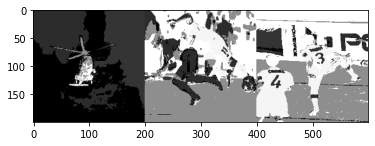

In [77]:
plt.imshow(B,cmap='gray') 

# Spatial Cue

192
111
[141 174 217]


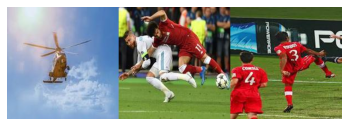

In [86]:
#Clustering based on colors
image = cv2.imread('Merge1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# show our image
plt.figure()
plt.axis("off")
plt.imshow(image)

gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
ret,thresh = cv2.threshold(gray_img,127,255,0)

moment = cv2.moments(thresh)

X = int(moment ["m10"] / moment["m00"])

Y = int(moment ["m01"] / moment["m00"])
print(X)
print(Y)
print(image[X,Y])

# image = image.reshape((image.shape[0] * image.shape[1], 3))

# image.shape # (120000,3)

# n_clusters =6
# clt = KMeans(n_clusters =n_clusters)
# clt.fit(image)


# (unique, counts) = np.unique(clt.labels_, return_counts=True)
# # print(unique)
# # print(counts)
# cluster_freq = dict(zip(unique,counts)) 
# print(cluster_freq)

